In [43]:
import sys
sys.path.append("../")
from matplotlib import pyplot as plt
from matplotlib.axes import Axes
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
from axessettings import AxesSetting, linear_sim

In [44]:
I_static = lambda V_DS, V_0, R_L:(V_0 - V_DS) / R_L

In [45]:
V_0 = 19.98
R_L = 19.81e3

In [46]:
V_GS = [0.0, 0.4, 0.8, 1.2, 1.6, 2.0, 2.4]
datas = pd.read_excel("data.xlsx", sheet_name=[f"(2)-{v:.2f}" for v in V_GS], skiprows=[1])
for v in V_GS:
    datas[v] = datas.pop(f"(2)-{v:.2f}")
    datas[v]["V_GS"] = v
    datas[v].sort_values(by="V_DS", axis=0, inplace=True, ascending=True)
    if v >= 1.2:
        datas[v].loc[:, "I_D"] *= 1e-6
    else:
        datas[v].loc[:, "I_D"] *= 1e-3

data_static = pd.read_excel("data.xlsx", sheet_name="(3)", skiprows=[0, 2], header=[0])
data_static["I_D"] = (V_0 - data_static["V_DS"]) / R_L

/tmp/ipykernel_2002/2213118508.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticks()*1e3)


[Text(0, 0.0, '0.0'),
 Text(0, 0.00025, '0.25'),
 Text(0, 0.0005, '0.5'),
 Text(0, 0.00075, '0.75'),
 Text(0, 0.001, '1.0'),
 Text(0, 0.00125, '1.25'),
 Text(0, 0.0015, '1.5'),
 Text(0, 0.00175, '1.75'),
 Text(0, 0.002, '2.0')]

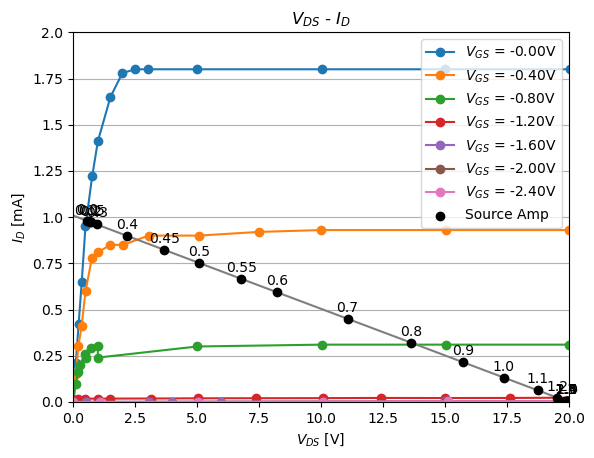

In [47]:


fig = plt.figure()
ax = fig.add_subplot(111)

axessetting = AxesSetting(legend=True, xlabel="$V_{DS}$ [V]", grid="y", ylabel="$I_D$ [mA]", title="$V_{DS}$ - $I_D$", xlim=(0, 20), ylim=(0, 0.002))
for v in V_GS:
    ax.plot(datas[v]["V_DS"], datas[v]["I_D"], label=f"$V_{{GS}}$ = {-v:.2f}V", marker="o")

axessetting.plot_func(ax, lambda vds: I_static(vds, V_0, R_L))
ax.scatter(data_static["V_DS"], data_static["I_D"], label="Source Amp", c="black", zorder=2)
for i in range(len(data_static)):
    ax.annotate(data_static["V_GS"][i], (data_static["V_DS"][i], data_static["I_D"][i]), textcoords="offset points", xytext=(0, 5), ha='center')

axessetting.apply_axes(ax)
ax.set_yticklabels(ax.get_yticks()*1e3)

In [67]:
def I_gs(V_GS, I_DSS, V_P):
    if V_GS > V_P:
        return I_DSS * (1 - V_GS / V_P)**2
    else:
        return 0.0
vI_gs = np.vectorize(I_gs, excluded=["I_DSS", "V_P"])
popt, _ = curve_fit(vI_gs, [-v for v in V_GS], [datas[v].iloc[-1]["I_D"] for v in V_GS], p0=[0.5e-3, -1.0])
print(popt)

[ 0.00180677 -1.38251011]


/tmp/ipykernel_2002/3902376493.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(-ax.get_xticks())
/tmp/ipykernel_2002/3902376493.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticks()*1e3)


[Text(0, 0.0, '0.0'),
 Text(0, 0.00025, '0.25'),
 Text(0, 0.0005, '0.5'),
 Text(0, 0.00075, '0.75'),
 Text(0, 0.001, '1.0'),
 Text(0, 0.00125, '1.25'),
 Text(0, 0.0015, '1.5'),
 Text(0, 0.00175, '1.75'),
 Text(0, 0.002, '2.0')]

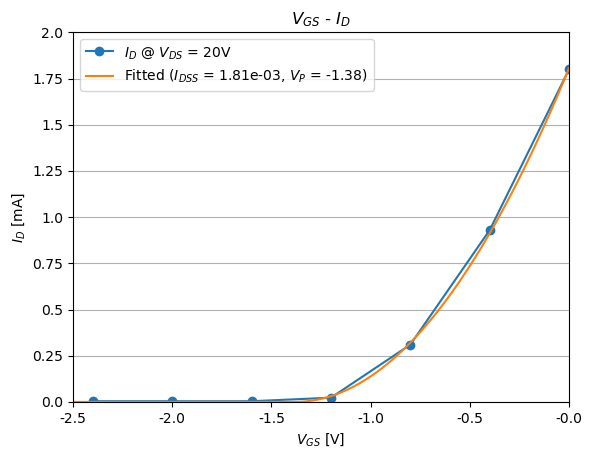

In [69]:
fig = plt.figure()
ax = fig.add_subplot(111)

axessetting = AxesSetting(legend=True, xlabel="$V_{GS}$ [V]", grid="y", ylabel="$I_D$ [mA]", title="$V_{GS}$ - $I_D$", xlim=(2.5, 0), ylim=(0, 0.002))

ax.plot(V_GS, [datas[v].iloc[-1]["I_D"] for v in V_GS], label="$I_D$ @ $V_{DS}$ = 20V", marker="o")
# ax.scatter(data_static["V_GS"], data_static["I_D"], marker="o", label="Source Amp", c="black")
axessetting.plot_func(ax, lambda vgs: vI_gs(-vgs, *popt), label="Fitted ($I_{{DSS}}$ = {:.2e}, $V_P$ = {:.2f})".format(*popt))
# for v in V_GS:
#     ax.scatter(datas[v]["V_GS"], datas[v]["I_D"], c=datas[v]["V_DS"].to_numpy(), vmin=0, vmax=20, cmap="binary")
axessetting.apply_axes(ax)
ax.set_xticklabels(-ax.get_xticks())
ax.set_yticklabels(ax.get_yticks()*1e3)